# Tutorial 4b: Model selection

*This tutorial was generated from an IPython notebook.  You can download the notebook [here](t4b_model_selection.ipynb).*

In this tutorial, we will apply some of the techniques of model selection we covered in lecture.  As in [Tutorial 4a](http://bebi103.caltech.edu/2014/tutorials/t4a_nonlinear_regression.html), we will use data from the Good, et al. paper and from the Reeves, Trisnadi, et al. paper.

Before we begin, as usual, we import the necessary modules.  You will need some functions I have written for you (in the file `jb_utils.py`), which you can download [here](http://bebi103.caltech.edu/2014/tutorials/jb_utils.py).

In [2]:
from __future__ import division, absolute_import, \
                                    print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

import emcee
import beeswarm
from brewer2mpl import sequential
import numdifftools as nd

# Utilities from JB
import jb_utils as jb

# Necessary to display plots in this IPython notebook
%matplotlib inline    

## Can use use Dorsal-Venus as a proxy for wild type Dorsal?

We will start with the Reeves, Trisnadi, et al. data.  In [Tutorial 4a](http://bebi103.caltech.edu/2014/tutorials/t4a_nonlinear_regression.html), we computed the width of gradients in a Dorsal-Venus fusion.  Earlier in the manuscript, the authors needs to prove that this fusion was a suitable replacement for wild type Dorsal.  Using antibody staining of wild tyle Dorsal as a gold standard, the authors compared various methods to measuring morphogen gradient widths along the DV coordinate.  These were summarized in Fig. 1F in the manuscript, reproduced below.

<img src="images/reeves_fig1F.png">

First, a comment on box plots.  Box plots were proposed by [John Tukey](http://en.wikipedia.org/wiki/John_Tukey) (the same John Tukey who developed the FFT algorithm) to give robust descriptions of data.  The bar in the middle of the box is the median of the collected data.  The top and bottom of the box represent the boundaries of the first and third quartiles.  The extrema on the whiskers represent the minimum and maximum values of the data, outliers excluded.  Outliers, in this case, are denoted with pluses.

How are outliers defined?  Typically, for box plots, an outliers is defined as follows.  The total length of the box is called the interquartile range ($IQR$), going from the first to the third quartile ($Q1$ and $Q3$, respectively).  I.e., $IQR = Q3 - Q1$.  A datum is an outlier if its value $x$ satisfies

\begin{align}
x < Q1 - \frac{3}{2}\,IQR,\\
\text{or } x > Q1 + \frac{3}{2}\,IQR.
\end{align}

The factor of $3/2$ is sometimes changed to $3$ to denote extreme outliers.

Finally, the numbers above each box and whisker give the number of repeats of that particular experiment.

The advantage of a box plot is that it summarizes the data consisely.  That said, when the number of data are not that large, I still prefer beeswarm plots, as they show all data.  (For fun, I show a beeswarm version of this figure at the end of this tutorial.)

Now, back to discussion of Fig. 1F of the Reeves, Trisnadi, et al. paper.  The gray region of the figure shows antibody staining of wild type.  The "wholemounts" method game from an earlier paper, and we will not consider that here.  The gold standard is the wild type cross-sections result.  The yellow portion of the plot contains measured gradient widths using the Dorsal-Venus fusion with a Dorsal-null background.  Finally, the green section shows measured gradients using a Dorsal-GFP fusion that had been used elsewhere in the literature.  The authors chose not to use the GFP fusion because it was less like the wild type antibody staining and, importantly, it fails to rescue the Dorsal phenotype.

We will make comparisons between wild-type cross sections (gold standard), anti-Dorsal, anti-Venus, and anti-GFP.  Anti-Dorsal and anti-Venus are antibody staining from the same Dorsal-Venus fusion.

### Loading the data set

Greg Reeves, Nathanie Trisnadi, and Angela Stathopoulos graciously provided us with the data used to generate Fig. 1F of their paper.  Let's load it into a DataFrame and check it out.

In [3]:
# Load data into DataFrame
file_name = '../data/reeves_et_al/reeves_gradient_width_various_methods.csv'
df = pd.read_csv(file_name, comment='#')

# Look at the DataFrame
df.head()

,wt wholemounts,wt cross-sections,anti-Dorsal dl1/+dl-venus/+,anti-Venus dl1/+dl-venus/+,Venus (live) dl1/+dl-venus/+,anti-Dorsal dl1/+dl-GFP/+,anti-GFP dl1/+dl-GFP/+,GFP (live) dl1/+dl-GFP/+
0,0.1288,0.1327,0.1482,0.1632,0.1666,0.2248,0.2389,0.2412
1,0.1554,0.1457,0.1503,0.1671,0.1753,0.1891,0.2035,0.1942
2,0.1306,0.1447,0.1577,0.1704,0.1705,0.1705,0.1943,0.2186
3,0.1413,0.1282,0.1711,0.1779,NaN,0.1735,0.2000,0.2104
4,0.1557,0.1487,0.1342,0.1483,NaN,0.2135,0.2560,0.2463


We'll choose convenient names for the three columns we want to analyze.

In [4]:
# Rename key columns
df.rename(columns={'wt cross-sections': 'wt', 
                   'anti-Dorsal dl1/+dl-venus/+': 'dorsal',
                   'anti-Venus dl1/+dl-venus/+': 'venus',
                   'anti-GFP  dl1/+dl-GFP/+': 'gfp'}, inplace=True)

To get a feel for the data, let's make beeswarm plots.

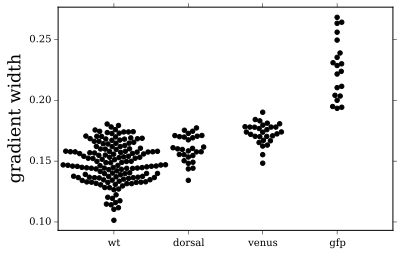

In [5]:
# Generate a beeswarm plot
bs_plot, ax = beeswarm.beeswarm(
        [df.wt.dropna(), df.dorsal.dropna(), df.venus.dropna(), 
         df.gfp.dropna()], 
        labels=['wt', 'dorsal', 'venus', 'gfp'])
plt.ylabel('gradient width')

# Adjust axis limits to account for wide wild type plot
plt.xlim((-0.75, 3.75));

Clear, the GFP fusion gives wider widths than the wild type.  The Dorsal and Venus fusions seem higher, but we would like to quantify this.

### A frequentist interlude

Before we begin Bayesian model selection, we will pause to perform the frequentist analysis that is often done in situations like these.  In this example, we wish to ask if two means (say $\mu_1$ and $\mu_2$) are different.  We will use **Student's t-test** and assign a p-value to the probability that the null hypothesis is true.  That last sentence was probably very confusing.  That's because it is.  Frequentist hypothesis testing can be difficult to get your head around because it does not have the elegant over-arching Bayes's Theorem on which everything is built.

We will now go through the basic procedure of frequentist hypothesis testing, using the present example as motivation.  We have two data sets, $1$ and $2$ (which could be wild type and Venus, for example).  We wish to test if they have the same mean.

To do a frequentist hypothesis test, we follow the following prescription (borrowing heavily from the treatment in [Gregory's excellent book](http://www.cambridge.org/us/academic/subjects/statistics-probability/statistics-physical-sciences-and-engineering/bayesian-logical-data-analysis-physical-sciences-comparative-approach-mathematica-support)).

1. Choose a null hypothesis.  This is the hypothesis you want to test the truth of.  In our case, it's the hypothesis that the means are the same, $|\mu_1 - \mu_2| = 0$.
2. Choose a suitable statistic that can be computed from measurements and has a predictable distribution.  For this example, we shoose as our statistic
\begin{align}
&\phantom{=} \\
T &= \frac{\bar{x}_1 - \bar{x}_2 - (\mu_1 - \mu_2)}{S_D\sqrt{n_1^{-1}+n_2^{-1}}},\\[1mm]
\text{where }S_D^2 &= \frac{(n_1 - 1)S_1^2 + (n_2-1)S_2^2}{n_1+n_2-2}, \\[1mm]
\text{with } S_1^2 &= \frac{1}{n_1-1}\sum_{i\in D_1}(x_i - \bar{x}_1)^2,
\end{align}
and $S_2^2$ similarly defined.  The T statistic is the difference of the difference of the observed means and the difference of the true means, weighted by the spread in the data.  This is a reasonable statistic for determining something about means from data.  This is the appropriate statistic when $\sigma_1$ and $\sigma_2$ are both unknown but assumed to be equal.  (When they are assumed to be unequal, you need to adjust the statistic you use.  This test is called **Welch's t-test**.)
This statistic has the Student-t distribution,
\begin{align}
&\phantom{=} \\
P(t) &= \frac{1}{\sqrt{\pi \nu}} \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)}
\left(1 + \left(\frac{t^2}{\nu}\right)\right)^{-\frac{\nu + 1}{2}},\\[1mm]
\text{where }
\nu &= n_1+n_2-2
\end{align}
3. Evaluate the statistic from measured data.  In this case, we compute $T$.
4. Plot $P(t)$.  The area under the curve where $|t| > |T|$ is the p-value, the probability that $\mu_1 - \mu_2 \ne 0$.  Reject the null hyopthesis if this is small.

There are some obvious problems with this approach.
1. You have to invent a different statistic/test for each hypothesis you wish to examine.
2. You can only reject or accept the null hypothesis.  This says nothing of alternative hypotheses and whether or not they should be accepted.
3. Under the hood, this is based on the frequentist assumption of infinite hypothetical experiments.  This leads to the *optional stopping problem*, which I will not get into here, but requires thought about hypothetical data that were not measured.  In frequentist-land, one cannot assign probabilities to parameter values, so this make intepretation difficult.

Another problem that may concern you is that the above calculation seems very involved.  Fortunately, there are packages that do this easily.  We will use `scipy.stats` to do all pairwise t-tests on our data sets of interest.  We will not do a t-test on Dorsal and Venus, since they are not independent data sets; each data point in the Dorsal set had a corresponding data point in the Venus set.  The function to do this is `scipy.stats.ttest_ind`, meaning that we are doing t-tests of independent measurements. 

In [6]:
# Compute T statistic and p-values for each pair
t, p_wt_dorsal = scipy.stats.ttest_ind(df.wt.dropna(), df.dorsal.dropna(), 
                                       equal_var=True)
t, p_wt_venus = scipy.stats.ttest_ind(df.wt.dropna(), df.venus.dropna(), 
                                      equal_var=True)
t, p_wt_gfp = scipy.stats.ttest_ind(df.wt.dropna(), df.gfp.dropna(), 
                                    equal_var=True)
t, p_dorsal_gfp = scipy.stats.ttest_ind(
            df.dorsal.dropna(), df.gfp.dropna(), equal_var=True)
t, p_venus_gfp = scipy.stats.ttest_ind(
            df.venus.dropna(), df.gfp.dropna(), equal_var=True)

# Print results
print("""
Constructs               p-values
==========               ========
WT/Dorsal                {0:.2e}
WT/Venus                 {1:.2e}
WT/GFP                   {2:.2e}
Dorsal/GFP               {3:.2e}
Venus/GFP                {4:.2e}
""".format(p_wt_dorsal, p_wt_venus, p_wt_gfp, p_dorsal_gfp, p_venus_gfp))


Constructs               p-values
==========               ========
WT/Dorsal                1.65e-04
WT/Venus                 1.84e-13
WT/GFP                   1.48e-43
Dorsal/GFP               8.05e-17
Venus/GFP                3.46e-14



Presumably, these small p-values tell us that, most likely, none of these means are equal.  This concludes our frequentist interlude, and we will now return to Bayes.

### Bayesian model selection

Section 9.4 of [Gregory's book](http://www.cambridge.org/us/academic/subjects/statistics-probability/statistics-physical-sciences-and-engineering/bayesian-logical-data-analysis-physical-sciences-comparative-approach-mathematica-support) gives a detailed account of how to do a Bayesian comparison of two independent samples.  I encourage you to read that.  We will instead take the approach of Sivia, as he lays out in section 4.3, which includes some simplifications, such as approximating distributions as Gaussians.

We set up the problem similarly as in our frequentist interlude.  We have two data sets (e.g., wild type and Venus), which we will call $1$ and $2$.  We have two models, $A$ and $B$.  Model $A$ states that both data sets come from the same 

We consider two models.  Model A states that the data in set 1 and set 2 were drawn from effectively the same process; that is to say, they are both drawn from Gaussian distributions with the same mean $\mu$ and standard deviation $\sigma$.  Model B states that the data in set 1 are different from set 2 in that they have different means, $\mu_1$ and $\mu_2$, but they have the same standard deviation $\sigma$.  As we learned in lecture, the **odds ratio** between model A and model B is

\begin{align}
O_{AB} = \frac{P(A~|~D,I)}{P(B~|~D,I)}.
\end{align}

Here, $D = D_1 + D_2$, the combined set of data.

By Bayes Theorem,

\begin{align}
P(A~|~D,I) = \frac{P(D~|~A,I)\,P(A~|~I)}{P(D~|~I)},
\end{align}

so

\begin{align}
O_{AB} = \frac{P(D~|~A,I)}{P(D~|~B,I)}\,\frac{P(A~|~I)}{P(B~|~I)}.
\end{align}


The final ratio is the ratio of our prior beliefs about the respective models.  We have no reason *a priori* to assume one is more probable than the other, so we set this ratio to unity.  We then have to compute $P(D~|~A,I)$ and $P(D~|~B,I)$.  We recognize these as the evidence in our familiar form of Bayes Theorem.

\begin{align}
P(\mu,\sigma~|~D,A,I) &= \frac{P(D~|~\mu,\sigma,A,I)\,P(\mu,\sigma~|~A,I)}{P(D~|~A,I)} \\[1mm]
P(\mu_1,\mu_2,\sigma~|~D,B,I) &= \frac{P(D~|~\mu_1,\mu_2,\sigma,B,I)\,P(\mu_1, \mu_2,\sigma~|~B,I)}{P(D~|~B,I)}.
\end{align}

Because the posterior has to be normalized, we have

\begin{align}
P(D~|~A,I) &= \int\mathrm{d}\sigma \int \mathrm{d}\mu \,P(D~|~\mu,\sigma,A,I)\,P(\mu,\sigma~|~A,I) \\[1mm]
P(D~|~B,I) &= \int\mathrm{d}\sigma \int \mathrm{d}\mu_1 \int\mathrm{d}\mu_2 \,P(D~|~\mu_1,\mu_2,\sigma,B,I)\,P(\mu_1, \mu_2,\sigma~|~B,I).
\end{align}

So, we just have to assign the priors and likelihoods, evaluate some integrals, and we have our odds ratio!

As we discussed in lecture, if the integrand in the above equations is sharply peaked (meaning the posterior is peaked), we can use Laplace's approximation to compute the integral.  In particular,

\begin{align}
P(D~|~A,I) &\approx P(D~|~\mu^*,\sigma^*,A,I)\,P(\mu^*,\sigma^*~|~A,I)\,\sqrt{2\pi \sigma_\mu^2\,\sigma_\sigma^2},
\end{align}

where $\sigma_\mu$ is the error in our estimate of $\mu$, $\sigma_\sigma$ is the error in the estimate of $\sigma$, and the asterisks indicate values for which the posterior is maximal.  (Here, we have made the approximation that $\mu$ and $\sigma$ are independent of each other.)  When we were doing parameter estimation, we found

\begin{align}
\mu^* &= \bar{x} = \frac{1}{n}\sum_{i\in D} x_i, \\[1mm]
(\sigma^*)^2 &= \frac{1}{n}\sum_{i\in D} (x_i - \bar{x})^2 \\[1mm]
\sigma_\mu^2 &= \frac{1}{n(n-1)}\sum_{i\in D} (x_i - \bar{x})^2.
\end{align}


We will assume a uniform prior for $\mu$,

\begin{align}
P(\mu~|~A,I) = \frac{1}{\mu_\mathrm{max} - \mu_\mathrm{min}},
\end{align}

so

\begin{align}
P(\mu^*,\sigma^*~|~A,I) = \frac{1}{\sigma^*(\mu_\mathrm{max} - \mu_\mathrm{min})}
\end{align}

Finally,

\begin{align}
P(D~|~\mu^*,\sigma^*,A,I) = \prod_{i\in D} \frac{1}{\sqrt{2\pi (\sigma^*)^2}}\,
\exp\left\{-\frac{(x_i - \mu^*)^2}{2(\sigma^*)^2}\right\}.
\end{align}

So, now we have all the pieces for $P(A~|~D,I)$.

We do a similar analysis for $P(B~|~D,I)$.

\begin{align}
P(D~|~B,I) &\approx P(D~|~\mu_1^*,\mu_2^*, \sigma^*,B,I)\,P(\mu_1^*,\mu_2^*,\sigma^*~|~B,I)\,\sqrt{2\pi \sigma_{\mu_1}^2\,\sigma_{\mu_2}^2\,\sigma_\sigma^2}
\end{align}


Because the samples are assumed to be independent of each other,

\begin{align}
P(D~|~\mu_1,\mu_2,\sigma,B,I) = P(D_1~|~\mu_1,\sigma,B,I)\,P(D_2~|~\mu_2,\sigma,B,I),
\end{align}

so we have

\begin{align}
P(D~|~\mu_1^*,\mu_2^*, \sigma^*,B,I) &= \prod_{i\in D_1} \frac{1}{\sqrt{2\pi (\sigma^*)^2}}\,
\exp\left\{-\frac{(x_i - \mu_1^*)^2}{2(\sigma^*)^2}\right\} \\[1mm]
&\times \prod_{i\in D_2} \frac{1}{\sqrt{2\pi (\sigma^*)^2}}\,
\exp\left\{-\frac{(x_i - \mu_2^*)^2}{2(\sigma^*)^2}\right\}.
\end{align}

Analogously to model A, we have

\begin{align}
\mu_1^* &= \bar{x}_1 = \frac{1}{n_1}\sum_{i\in D_1} x_i, \\[1mm]
\mu_2^* &= \bar{x}_2 = \frac{1}{n_2}\sum_{i\in D_2} x_i, \\[1mm]
\sigma_{\mu_1}^2 &= \frac{1}{n_1(n_1-1)}\sum_{i\in D_1} (x_i - \bar{x}_1)^2,\\[1mm]
\sigma_{\mu_2}^2 &= \frac{1}{n_2(n_2-1)}\sum_{i\in D_2} (x_i - \bar{x}_2)^2.
\end{align}

Finally, we assume $\mu_1$ and $\mu_2$ have the same prior as $\mu$, giving

\begin{align}
P(\mu_1^*,\mu_2^*,\sigma^*~|~B,I) = \frac{1}{\sigma^*(\mu_\mathrm{max} - \mu_\mathrm{min})^2}.
\end{align}

We now have all the pieces of $P(B~|~D,I)$!

Putting it all together and canceling terms,

\begin{align}
O_{AB} &= (\mu_\mathrm{max} - \mu_\mathrm{min})\,\frac{\sigma_\mu}{\sigma_{\mu_1}\sigma_{\mu_2}}\\[1mm]
&\times \exp\left\{-\frac{1}{2(\sigma^*)^2}\left(\sum_{i\in D}(x_i - \mu^*)^2 - \sum_{i\in D_1}(x_i - \mu_1^*)^2 - \sum_{i\in D_2}(x_i - \mu_2^*)^2\right)\right\}.
\end{align}

In the case of the Reeves, Trisnadi, et al. data, we will assume $\mu_\mathrm{min} = 0$ (an infinitely sharp morphogen gradient) and $\mu_\mathrm{max} = 7.5$ (the gradient is barely detectable; the morphogen profile only varies abour 1%).  Let's go ahead and calculate the odds ratio.  We will do it over and over again, so let's write a function.

In [7]:
def log_odds_ratio(x_1, x_2, mu_range):
    """
    Computes the odds ratio for two data sets, x_1 and x_2.  
    Model A: data sets have same mean
    Model B: data sets have different means
    
    Returns ln(prob(A) / prob(B)).
    
    Assumes the data sets are both Gaussian distributed and  have the same 
    variance.  Uses Laplace's approximation to compute the evidence.
    """
    # Get length of data sets for convenience
    n_1 = float(len(x_1))
    n_2 = float(len(x_2))
    n = n_1 + n_2
    
    # Construct master data set
    x = np.concatenate((x_1, x_2))
   
    # Compute means of sets
    x_bar = x.mean()
    x_1_bar = x_1.mean()
    x_2_bar = x_2.mean()
    
    # Compute most probable sigma (same for both data sets)
    sigma_sq = ((x - x_bar)**2).sum() / n
    
    # Compute sigma_mu's
    sigma_mu_sq = sigma_sq / (n - 1.0)
    sigma_mu_1_sq = ((x_1 - x_1_bar)**2).sum() / n_1 / (n_1 - 1.0)
    sigma_mu_2_sq = ((x_2 - x_2_bar)**2).sum() / n_2 / (n_2 - 1.0)

    # Compute parts in exponential
    sum_exp = ((x - x_bar)**2).sum() - ((x_1 - x_1_bar)**2).sum() \
                    - ((x_2 - x_2_bar)**2).sum()
    
    # Add everything up to return
    return np.log(mu_range) \
           + 0.5 * (np.log(sigma_mu_sq) - np.log(sigma_mu_1_sq) 
                     - np.log(sigma_mu_1_sq)) \
           - sum_exp / 2.0 / sigma_sq

An now, let's compute the odds ratio for each of our pairs.

In [8]:
mu_range = 7.5
o_wt_dorsal = np.exp(log_odds_ratio(df.wt.dropna(), df.dorsal.dropna(), 
                                    mu_range))
o_wt_venus = np.exp(log_odds_ratio(df.wt.dropna(), df.venus.dropna(), 
                                   mu_range))
o_wt_gfp = np.exp(log_odds_ratio(df.wt.dropna(), df.gfp.dropna(), 
                                 mu_range))
o_dorsal_gfp = np.exp(log_odds_ratio(df.dorsal.dropna(), df.gfp.dropna(), 
                                       mu_range))
o_venus_gfp = np.exp(log_odds_ratio(df.venus.dropna(), df.gfp.dropna(), 
                                       mu_range))

# Print results
print("""
Constructs               p-values            Odds ratios
==========               ========            =========== 
WT/Dorsal                {0:.2e}             {5:.2e}
WT/Venus                 {1:.2e}             {6:.2e}
WT/GFP                   {2:.2e}             {7:.2e}
Dorsal/GFP               {3:.2e}             {8:.2e}
Venus/GFP                {4:.2e}             {9:.2e}
""".format(p_wt_dorsal, p_wt_venus, p_wt_gfp, p_dorsal_gfp, p_venus_gfp, 
           o_wt_dorsal, o_wt_venus, o_wt_gfp, o_dorsal_gfp, o_venus_gfp))


Constructs               p-values            Odds ratios
==========               ========            =========== 
WT/Dorsal                1.65e-04             5.17e+00
WT/Venus                 1.84e-13             2.97e-07
WT/GFP                   1.48e-43             5.32e-22
Dorsal/GFP               8.05e-17             5.63e-05
Venus/GFP                3.46e-14             3.64e-04



The odds ratios favor the null hypothesis (model A) more than we might expect from looking at the p-values, particularly the WT/Dorsal pair.  Note, though, that the range of values of $\mu$ from the prior have a strong effect on the odds ratio.  Nonetheless, even for small values of $\mu$ (like $\mu = 1$), there is still a substantial probability that model A (the same mean) is true.  This is because the penalty of having an extra parameter due to the Occam factor tends to favor simpler models with fewer parameters.

### Of course the means are different. How different are they?

In the above analysis, we assumed $P(A~|~I) = P(B~|~I)$.  I cavalierly said that we had no *a priori* reason to favor one over the other.  But is this so?  *Of course not!*  We would *expect* the means to be different!  We are looking at different molecules after all.  We also expect $\sigma$ to be different.

So, perhaps the better question is: how different are they?  Specifically, we would like to know

\begin{align}
P(\delta, \sigma_1, \sigma_2~|~D_1, D_2, I),
\end{align}

where $\delta = \mu_1 - \mu_2$.  This is essentially the [Behrens-Fisher problem](http://en.wikipedia.org/wiki/Behrens–Fisher_problem), and there are analytical expressions for it (e.g., in section 9.4.4 of Gregory's book).

But let's not bother with that.  Let's just use MCMC!  We will sample

\begin{align}
P(\mu_1, \mu_2, \sigma_1, \sigma_2~|~D_1, D_2, I) &\propto P(\mu_1, \sigma_1~|~D_1, I)\,P(\mu_2, \sigma_2~|~D_2, I)\\[1mm]
&\times P(\mu_1~|~I)\,P(\mu_2~|~I)\,P(\sigma_1~|~I)\,P(\sigma_2~|~I),
\end{align}

and from this we can compute $P(\delta, \sigma_1, \sigma_2~|~D_1, D_2, I)$.  We will use a uniform prior on $\mu_1$ and $\mu_2$ and Jeffreys priors on $\sigma_1$ and $\sigma_2$.

First, we define the log posterior.

In [8]:
# Define log of the posterior
def log_posterior(p, x_1, x_2, mu_min, mu_max):
    """
    Returns the log of the posterior consisting of the product of Gaussians.
    p[0] = mu_1
    p[1] = mu_2
    p[2] = sigma_1
    p[3] = sigma_2
    """
    # Unpack parameters
    mu_1, mu_2, sigma_1, sigma_2 = p
    
    # Make sure we have everything in the right range
    if (mu_min < mu_1 < mu_max) and (mu_min < mu_2 < mu_max) \
              and (sigma_1 > 0.0) and (sigma_2 > 0.0): 
        n_1 = len(x_1)
        n_2 = len(x_2)
        
        # Compute separate parts of posterior from each sample
        log_post_1 = -(n_1 + 1) * np.log(sigma_1) \
           - ((x_1 - mu_1)**2).sum() / 2.0 / sigma_1**2
        log_post_2 = -(n_2 + 1) * np.log(sigma_2) \
           - ((x_2 - mu_2)**2).sum() / 2.0 / sigma_2**2

        # Add them up to return
        return log_post_1 + log_post_2
    else:
        # Return minus infinity where posterior is zero
        return -np.inf

Now set up the MCMC parameters.

In [9]:
n_dim = 4        # number of parameters in the model
n_walkers = 50   # number of MCMC walkers
n_burn = 500    # "burn-in" period to let chains stabilize
n_steps = 5000 # number of MCMC steps to take after burn-in

We need to define the range of our prior.

In [10]:
# Define the range of mu
mu_min = 0.0
mu_max = 7.5

Proceeding as before: set up starting points of walkers.

In [11]:
# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(mu_min, mu_max, n_walkers)     # mu_1
p0[:,1] = np.random.uniform(mu_min, mu_max, n_walkers)     # mu_2
p0[:,2] = np.random.exponential(1.0, n_walkers)            # sigma_1
p0[:,3] = np.random.exponential(1.0, n_walkers)            # sigma_2

Now we'll instantiate the sampler, do the burn in, and then do our sampling!  For this run, we'll compare wild type and Venus.  Remember, $\mu_1$ in this case is the mean gradient width for wild type, $\mu_2$ is the mean gradient width for Venus, $\sigma_1$ is the standard deviation describing spread in the wild type gradient width measurements, and $\sigma_1$ is the standard deviation describing spread in the Venus gradient width measurements.

In [12]:
# Set up the EnsembleSampler instance
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, 
                            args=(df.wt, df.venus, mu_min, mu_max))

# Do the burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn)

# Reset sampler and run from the burn-in state we got to
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, n_steps)

To see the probability distribution of difference of means between wild type and Venus, we simple do a histogram of the samples we took during the MCMC calculation.

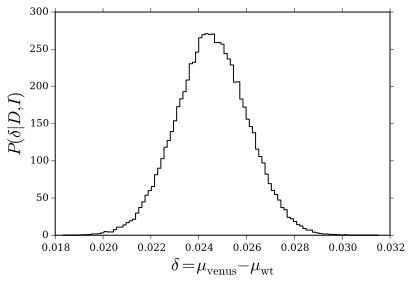

In [64]:
# Plot the histogram of mean differences
n, b, p = plt.hist(sampler.flatchain[:,1] - sampler.flatchain[:,0], 
                   bins=100, normed=True, histtype='step', color='k')

# Label axes
plt.xlabel(r'$\delta = \mu_\mathrm{venus} - \mu_\mathrm{wt}$')
plt.ylabel(r'$P(\delta|D,I)$');

The difference in the mean between wild type and Venus is about 0.025, or approximately 15% of the wild type gradient width.

This is far more informative to the scientist than whether or not we can reject a null hypothesis that the means are the same.

## Model selection for the Good, et al. data

Recall from last time that we were considering two different theoretical models for the spindle length vs. droplet size data presented in Good, et al.

#### Model 1

In Model 1, the spindle size is independent of droplet size.  The corresponding equation is

\begin{align}
l = \theta.
\end{align}

#### Model 2

We define by Model 2 the full relation between spindle length and droplet diameter,

\begin{align}
l(d;\gamma,\theta) \approx \frac{\gamma d}{\left(1+(\gamma d/\theta)^3\right)^{\frac{1}{3}}}.
\end{align}

In [Tutorial 4a](http://bebi103.caltech.edu/2014/tutorials/t4a_nonlinear_regression.html), we performed a regression using Model 2.  We repeat that here to get the results.

In [9]:
# Load data into DataFrame
df = pd.read_csv('../data/good_et_al/invitro_droplet_data.csv', 
                 comment='#')

# Rename columns
df.columns = ['droplet_diameter', 'droplet_volume', 'spindle_length', 
              'spindle_width', 'spindle_area']

# Define fit function
def good_fit_fun(d, gamma, theta):
    """
    Theoretical model for spindle length dependence on droplet diameter
    """
    return gamma * d / scipy.special.cbrt(1.0 + (gamma * d / theta)**3)

# Define marginalized log of posterior
def good_log_marg_posterior(p, d, ell):
    """
    Log of posterior for spindle length up to additive constant.
    
    Assumes uniform priors for all parameters.
    """
    return -len(d) / 2.0 * np.log(((ell - good_fit_fun(d, *p))**2).sum())

# Initial guess
gamma_0 = 0.5
theta_0 = 50.0  # microns
p0 = np.array([gamma_0, theta_0])

# Find most probable parameters
popt, junk_output = scipy.optimize.curve_fit(
            good_fit_fun, df.droplet_diameter, df.spindle_length, p0)

# Compute covariance
hess = jb.hess_nd(good_log_marg_posterior, popt, 
                  (df.droplet_diameter, df.spindle_length))
cov_model_2 = -np.linalg.inv(hess)

# Unpack and report results
gamma, theta_model_2 = popt
print("""
gamma =  {0:.3f} += {1:.3f}
theta = {2:.3f} += {3:.3f} µm
""".format(popt[0], np.sqrt(cov_model_2[0,0]), 
           popt[1], np.sqrt(cov_model_2[1,1])))


gamma =  0.860 += 0.017
theta = 38.247 += 0.392 µm



We need to perform a parameter estimation calculation for Model 1 to be able to make comparisons.  We derived analytical expressions in Tutorial 3b, but we will just use `scipy.optimize.curve_fit` here.

In [10]:
# Define fit function
def model_1_fit_fun(d, theta):
    """
    Theoretical model for spindle length dependence on droplet diameter
    """
    return theta

# Define marginalized log of posterior
def model_1_log_marg_posterior(p, d, ell):
    """
    Log of posterior for spindle length up to additive constant.
    
    Assumes uniform priors for all parameters.
    """
    return -len(d) / 2.0 * np.log(((ell - model_1_fit_fun(d, *p))**2).sum())

# Initial guess
theta_0 = 50.0  # microns
p0 = np.array([theta_0])

# Find most probable parameters
popt, junk_output = scipy.optimize.curve_fit(
            model_1_fit_fun, df.droplet_diameter, df.spindle_length, p0)

# Compute covariance
hess = jb.hess_nd(model_1_log_marg_posterior, popt, 
                  (df.droplet_diameter, df.spindle_length))
cov_model_1 = -np.linalg.inv(hess)

# Unpack and report results
theta_model_1 = popt[0]
print("""
theta = {0:.3f} += {1:.3f} µm
""".format(popt[0], np.sqrt(cov_model_1[0,0])))


theta = 32.864 += 0.185 µm



We can now compute the odds ratio between these two models using the approximate equation we derived in class.

\begin{align}
O_{12} = \frac{P(M_1~|~I)}{P(M_2~|~I)}\,\frac{P(D~|~\theta^*,\sigma^*,M_1,I)}{P(D~|~\gamma^*,\theta^*,\sigma^*,M_2,I)} \,
\frac{P(\theta^*,\sigma^*~|~M_1,I)}{P(\gamma^*,\theta^*,\sigma^*~|~M_2,I)} \,
\sqrt{\frac{\det \sigma_{M_1}}{\det \sigma_{M_2}}}.
\end{align}

We take the first ratio to be unity.  The second ratio is computed directly from the likelihood at the most probable parameter values.

As derived in class, for Model 1,

\begin{align}
\sigma^* = \sqrt{\frac{1}{n-1}\sum_{i\in D}(l_i - \theta^*)^2}.
\end{align}

For Model 2,

\begin{align}
\sigma^* = \sqrt{\frac{1}{n-1}\sum_{i\in D}(l_i - l(d_i;\gamma^*,\theta^*))^2}.
\end{align}

The likelihoods are both Gaussian with $\sigma = \sigma^*$ at their maxima.


The third ratio is a ratio of priors.  We take unform priors in both, with

\begin{align}
P(\theta~|~M_1,I) &= \frac{1}{1000\text{ microns}},\\[1mm]
P(\gamma,\theta~|~M_2,I) &= \frac{1}{1000\text{ microns}},
\end{align}

since the domain of $\gamma$ is $[0,1]$.  This, combined with Jeffreys priors for $\sigma$ for each, leads to the third ratio just canceling out.  Finally, the last ratio is the ratio of the determinants of the covariance matrices.  We can go ahead and calculate the odds ratio now.

In [11]:
# Get n for convenience
n = float(len(df.spindle_length))

# Compute most probable sigmas
sigma2_model_1 = ((df.spindle_length - theta_model_1)**2).sum() / (n - 1)
sigma2_model_2 = ((df.spindle_length \
    - good_fit_fun(df.droplet_diameter, gamma, theta_model_2))**2).sum() \
    / (n - 1)

# Log of ratio of likelihoods
log_like_ratio = -n / 2.0 * np.log(sigma2_model_1)\
        - ((df.spindle_length - theta_model_1)**2).sum() \
        / (2.0 * sigma2_model_1) \
        + n / 2.0 * np.log(sigma2_model_2)\
        + ((df.spindle_length \
        - good_fit_fun(df.droplet_diameter, gamma, theta_model_2))**2).sum()\
        / (2.0 * sigma2_model_2)

# Log of the Occam factor
log_occam_factor = (np.log(np.linalg.det(cov_model_1)) \
                     -np.log(np.linalg.det(cov_model_2))) / 2.0

# Odds ratio
log_odds_ratio = log_like_ratio + log_occam_factor

print('Likelihood ratio = ', np.exp(log_like_ratio))
print('Occam factor = ', np.exp(log_occam_factor))
print('Odds ratio = ', np.exp(log_odds_ratio))

Likelihood ratio =  3.07694009195e-71
Occam factor =  44.0378138933
Odds ratio =  1.3550171513e-69


We see that the goodness of fit strongly overwhelms the Occam factor presented by the simpler model.  Model 2 is the clear winner!  Spindle size is dependent on droplet volume!